# Diamond price prediction Capstone Project

https://www.kaggle.com/datasets/shivam2503/diamonds

- price price in US dollars (\$326--\$18,823)

- carat weight of the diamond (0.2--5.01)

- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- color diamond colour, from J (worst) to D (best)

- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- x length in mm (0--10.74)

- y width in mm (0--58.9)

- z depth in mm (0--31.8)

- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- table width of top of diamond relative to widest point (43--95)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor

from tqdm.auto import tqdm

## 1. Cleaning and EDA

In [2]:
data = pd.read_csv('resources/diamonds.csv')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
data.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [4]:
#drop unnamed:0 column

df = data.drop(['Unnamed: 0'], axis=1)
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [5]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [6]:
df.describe().round()

,carat,depth,table,price,x,y,z
count,53940.0,53940.0,53940.0,53940.0,53940.0,53940.0,53940.0
mean,1.0,62.0,57.0,3933.0,6.0,6.0,4.0
std,0.0,1.0,2.0,3989.0,1.0,1.0,1.0
min,0.0,43.0,43.0,326.0,0.0,0.0,0.0
25%,0.0,61.0,56.0,950.0,5.0,5.0,3.0
50%,1.0,62.0,57.0,2401.0,6.0,6.0,4.0
75%,1.0,62.0,59.0,5324.0,7.0,7.0,4.0
max,5.0,79.0,95.0,18823.0,11.0,59.0,32.0


In [7]:
categorical = [
    'cut',
    'color',
    'clarity'
]

numerical = [
    'carat',
    'depth',
    'table',
    'x',
    'y',
    'z',
]

features = categorical + numerical

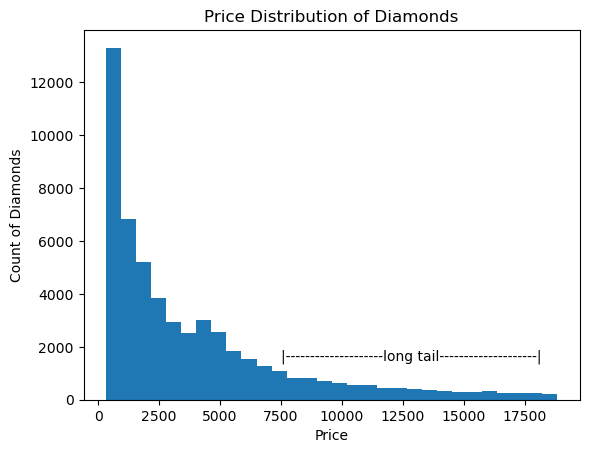

In [8]:
hist = plt.hist(df.price, 30)

plt.xlabel('Price')
plt.text(7500, 1500, '|--------------------long tail--------------------|')
plt.ylabel('Count of Diamonds')
plt.title('Price Distribution of Diamonds')
plt.show()

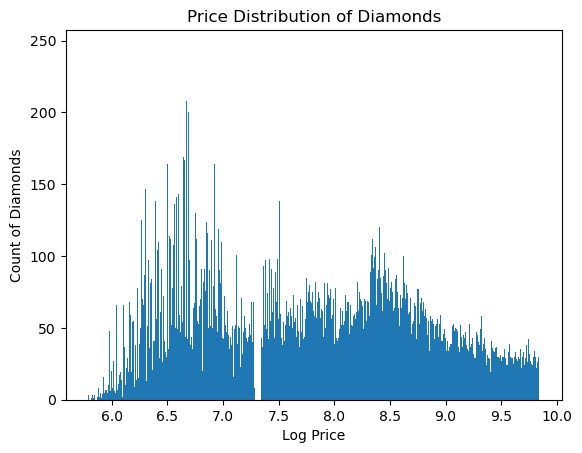

In [9]:
price_logs = np.log1p(df.price)

hist = plt.hist(price_logs, 1000)
plt.xlabel('Log Price')
plt.ylabel('Count of Diamonds')
plt.title('Price Distribution of Diamonds')
plt.show()

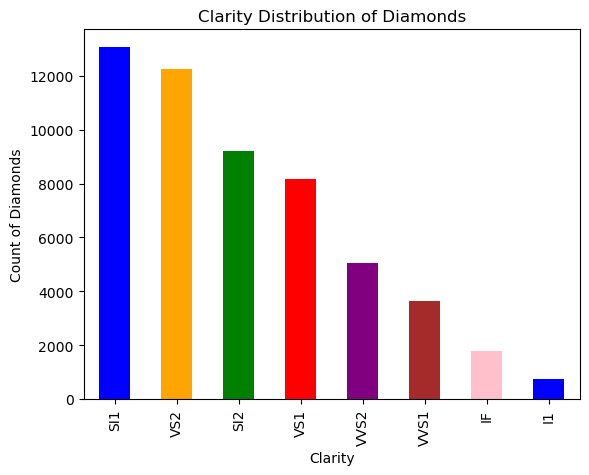

In [10]:
colors= ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

plt.title('Clarity Distribution of Diamonds')
df['clarity'].value_counts().plot.bar(color=colors)
plt.xlabel('Clarity')
plt.ylabel('Count of Diamonds')
plt.show()

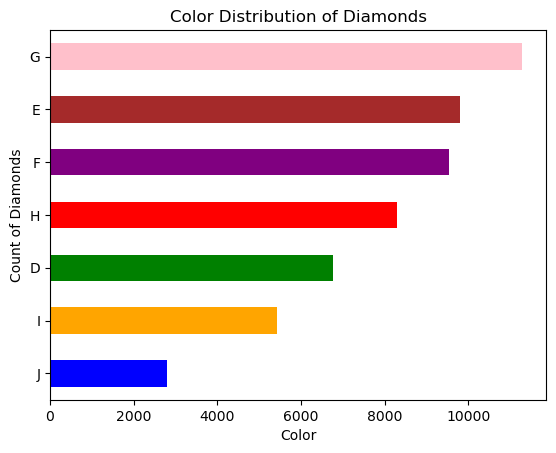

In [11]:
colors= ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']


df['color'].value_counts().sort_values(ascending=True).plot(color=colors, kind='barh')
plt.title('Color Distribution of Diamonds')
plt.xlabel('Color')
plt.ylabel('Count of Diamonds')
plt.show()

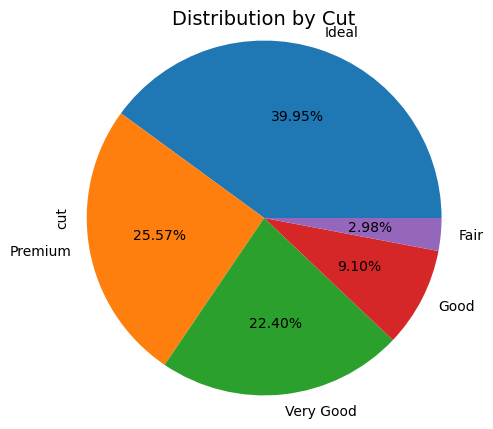

In [12]:
df['cut'].value_counts().plot.pie(radius=1.2,autopct='%0.2f%%')
plt.title('Distribution by Cut', fontsize=14)
plt.show()

In [13]:
df[numerical].corrwith(df.price)

carat    0.921591
depth   -0.010647
table    0.127134
x        0.884435
y        0.865421
z        0.861249
dtype: float64

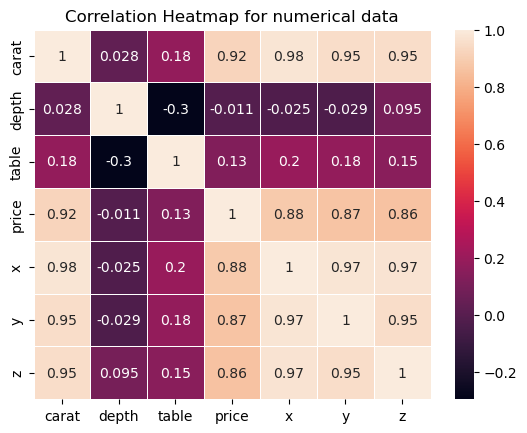

In [14]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5)
plt.title('Correlation Heatmap for numerical data')
plt.show()

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [16]:
def mutual_info_price_score(series):
    return mutual_info_score(series, df_full_train.price)

mi = df_full_train[categorical].apply(mutual_info_price_score)
mi.sort_values(ascending=False)

clarity    0.936861
color      0.908796
cut        0.530820
dtype: float64

In [17]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)

del df_train['price']
del df_val['price']

In [18]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [19]:
val_dicts= df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

## 2. Models

### 2.1 Linear Regression 

In [20]:
lreg = LinearRegression()

In [21]:
lreg.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = lreg.predict(X_val)

In [23]:
rmse = np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)
r2 = r2_score(y_val, y_pred)
print (f'RMSE Score: {rmse}, R2: {r2}')

RMSE Score: 0.2, R2: 0.9615332535264208


### 2.2 Decision Trees

In [24]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [25]:
y_pred = dt.predict(X_val)

In [26]:
np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)

0.13

In [27]:
r2 = r2_score(y_val, y_pred)
r2

0.9839747835712986

In [28]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    score = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f'depth: {depth}, rmse: {round((score),3)}, r2: {round((r2),3)}')

depth: 1, rmse: 0.281, r2: 0.726
depth: 2, rmse: 0.124, r2: 0.879
depth: 3, rmse: 0.076, r2: 0.926
depth: 4, rmse: 0.062, r2: 0.939
depth: 5, rmse: 0.052, r2: 0.949
depth: 6, rmse: 0.043, r2: 0.958
depth: 10, rmse: 0.021, r2: 0.98
depth: 15, rmse: 0.015, r2: 0.985
depth: 20, rmse: 0.016, r2: 0.984
depth: None, rmse: 0.017, r2: 0.984


In [29]:
scores = []

for m in tqdm([1, 2, 3, 4, 5, 6, 10, 15, 20, None]):
    #print('depth: %s' % m)
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        scores.append((m, s, score, r2))
        #print(f'depth: {m}, mean leafs: {s}, rmse: {round((score),3)}, r2: {round((r2),3)}')

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
columns = ['max_depth', 'min_sample_leaves', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores = df_scores.sort_values(by='rmse', ascending=True)
df_scores

,max_depth,min_sample_leaves,rmse,r2
65,20.0,5,0.114422,0.987239
73,NaN,5,0.114549,0.987211
57,15.0,5,0.116183,0.986843
66,20.0,10,0.117196,0.986613
74,NaN,10,0.117196,0.986613
...,...,...,...,...
2,1.0,10,0.529859,0.726361
0,1.0,1,0.529859,0.726361
3,1.0,15,0.529859,0.726361
1,1.0,5,0.529859,0.726361


In [31]:
df_scores_pivot =  df_scores.pivot(index='min_sample_leaves',
                                   columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                                                 \
max_depth            NaN  1.0    2.0    3.0   4.0    5.0    6.0    10.0   
min_sample_leaves                                                         
1                  0.128  0.53  0.352  0.276  0.25  0.229  0.207  0.144   
5                  0.115  0.53  0.352  0.276  0.25  0.229  0.206  0.143   
10                 0.117  0.53  0.352  0.276  0.25  0.229  0.208  0.144   
15                 0.119  0.53  0.352  0.276  0.25  0.229  0.208  0.145   
20                 0.125  0.53  0.352  0.276  0.25  0.229  0.208  0.147   
50                 0.144  0.53  0.352  0.276  0.25  0.230  0.209  0.158   
100                0.171  0.53  0.352  0.276  0.25  0.232  0.212  0.175   
200                0.194  0.53  0.352  0.276  0.25  0.232  0.214  0.196   

                                 
max_depth           15.0   20.0  
min_sample_leaves                
1                  0.121  0.126  
5                  0.116  0.114  
10                 0.120  0.117  
15                 0.122  0.119  
20                 0.127  0.125  
50                 0.145  0.144  
100                0.171  0.171  
200                0.194  0.194

<AxesSubplot:xlabel='None-max_depth', ylabel='min_sample_leaves'>

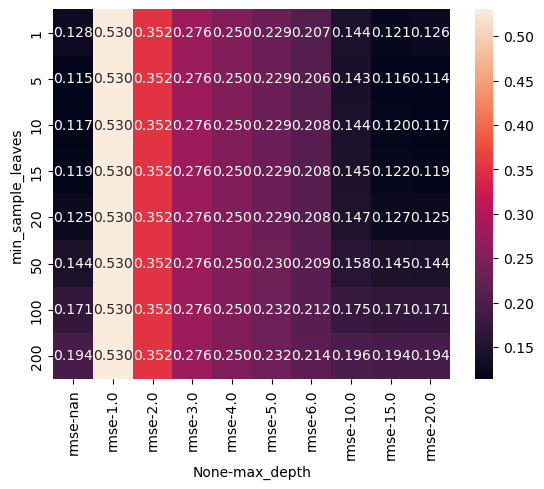

In [32]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

### 2.3 Random Forest

In [33]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [34]:
y_pred = rf.predict(X_val)

In [35]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print (f'RMSE Score: {rmse}, R2: {r2}')

RMSE Score: 0.2, R2: 0.9913832642359784


#### *2.3.1 Tuning RF Parameters: n_estimators*

In [36]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    scores.append((n, score, r2))

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
columns = ['n_estimators', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores = df_scores.sort_values(by='rmse', ascending=True)
df_scores.head(10)

,n_estimators,rmse,r2
17,180,0.093525,0.991475
18,190,0.093540,0.991472
19,200,0.093558,0.991469
16,170,0.093603,0.991460
15,160,0.093605,0.991460
12,130,0.093610,0.991459
14,150,0.093615,0.991458
13,140,0.093637,0.991454
11,120,0.093675,0.991447
10,110,0.093741,0.991435


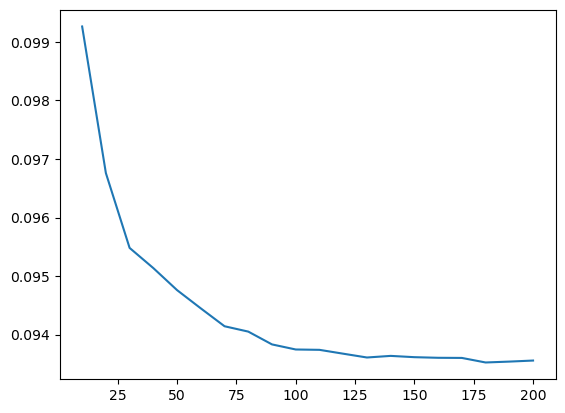

In [38]:
columns = ['n_estimators','rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

#### *2.3.1 Tuning RF Parameters: n_estimators and depth*

In [39]:
scores = []

for d in tqdm([5, 10, 15, 20, 25, 30, None]):
    
    for n in tqdm(range(10, 201, 10)):
        
        rf = RandomForestRegressor(n_estimators=n,
                                        max_depth=d,
                                        random_state=1,
                                        n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        scores.append((n, d, score, r2))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [40]:
columns = ['n_estimators', 'max_depth', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='rmse', ascending=True).head(15)

,n_estimators,max_depth,rmse,r2
97,180,25.0,0.093402,0.991497
98,190,25.0,0.093435,0.991491
99,200,25.0,0.093447,0.991489
117,180,30.0,0.093452,0.991488
118,190,30.0,0.093463,0.991486
96,170,25.0,0.093477,0.991483
112,130,30.0,0.093478,0.991483
95,160,25.0,0.093484,0.991482
115,160,30.0,0.093487,0.991481
119,200,30.0,0.093488,0.991481


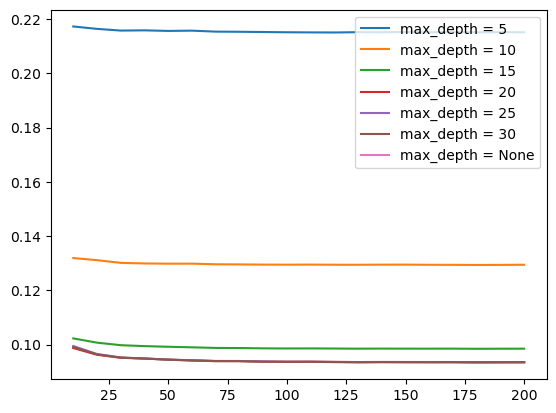

In [41]:
for d in [5, 10, 15, 20, 25, 30, None]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')
    
plt.legend()
plt.show()

In [42]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(5)

,feature,importance
24,y,0.846639
0,carat,0.082339
23,x,0.019417
4,clarity=SI2,0.009791
3,clarity=SI1,0.007275


### 2.4 XGBoost

#### *2.3.1 Tuning XGBoost Parameters: eta*

In [43]:
import xgboost as xgb

In [44]:
features = dv.get_feature_names_out()
features

array(['carat', 'clarity=I1', 'clarity=IF', 'clarity=SI1', 'clarity=SI2',
       'clarity=VS1', 'clarity=VS2', 'clarity=VVS1', 'clarity=VVS2',
       'color=D', 'color=E', 'color=F', 'color=G', 'color=H', 'color=I',
       'color=J', 'cut=Fair', 'cut=Good', 'cut=Ideal', 'cut=Premium',
       'cut=Very Good', 'depth', 'table', 'x', 'y', 'z'], dtype=object)

In [45]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [46]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [47]:
scores_eta = {}
# 0.3, 0.2, 0.15, 0.1, 0.05, 0.01

In [73]:
%%capture output
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [74]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [75]:
#the output is captured by "%%capture output"
df_score = parse_xgb_output(output)
df_score

,num_iter,train_rmse,val_rmse
0,0,7.28157,7.28176
1,1,7.20887,7.20905
2,2,7.13690,7.13707
3,3,7.06564,7.06579
4,4,6.99510,6.99524
...,...,...,...
95,95,2.81053,2.80915
96,96,2.78257,2.78119
97,97,2.75489,2.75350
98,98,2.72748,2.72610


In [76]:
key_text_eta = f"eta = {xgb_params['eta']}"
scores_eta[key_text_eta] = parse_xgb_output(output)
key_text_eta

'eta = 0.01'

In [77]:
scores_eta.keys()

dict_keys(['eta = 0.3', 'eta = 0.2', 'eta = 0.15', 'eta = 0.1', 'eta = 0.05', 'eta = 0.01'])

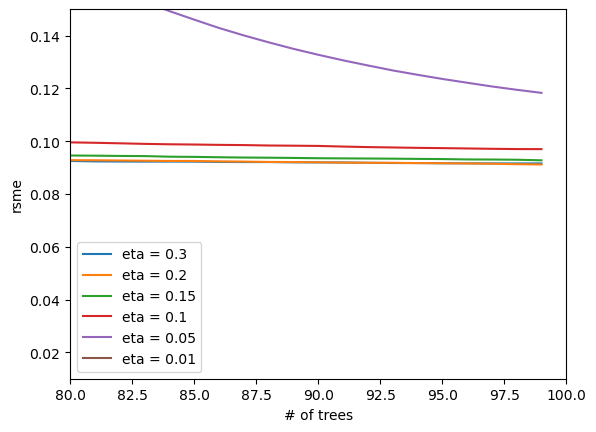

In [78]:
for key_eta, df_score in scores_eta.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key_eta)

plt.ylabel('rsme')
plt.xlabel('# of trees')

#zoom
plt.xlim((80, 100))
plt.ylim((0.01, 0.150))


plt.legend()
plt.show()

# eta 0.2

In [79]:
y_pred = model.predict(dval)

In [80]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(2.698972954165513, -6.099955476555747)

#### *2.3.2 Tuning XGBoost Parameters: max_depth*

In [81]:
scores_depth = {}
# 1, 3, 5, 10, 15, 20

In [102]:
%%capture output
xgb_params = {
    'eta': 0.2, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [103]:
key_text_depth = f"max_depth = {xgb_params['max_depth']}"
scores_depth[key_text_depth] = parse_xgb_output(output)
key_text_depth

'max_depth = 20'

In [104]:
scores_depth.keys()

dict_keys(['max_depth = 1', 'max_depth = 3', 'max_depth = 5', 'max_depth = 10', 'max_depth = 15', 'max_depth = 20'])

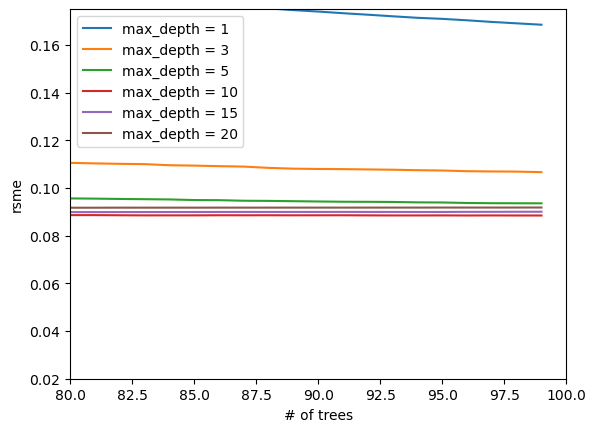

In [105]:
for key_text_depth, df_score in scores_depth.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key_text_depth)

plt.ylabel('rsme')
plt.xlabel('# of trees')

plt.ylabel('rsme')
plt.xlabel('# of trees')

plt.xlim((80, 100))
plt.ylim((.02, 0.175))


plt.legend()
plt.show()

#max_depth 10

#### 2.3.2 Tuning XGBoost Parameters: min_child_weight

In [106]:
scores_min_child = {}
# 1, 5, 10, 15, 25

In [123]:
%%capture output
xgb_params = {
    'eta': 0.2, 
    'max_depth': 10,
    'min_child_weight': 25,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [124]:
key_text_min = f"min_child = {xgb_params['min_child_weight']}"
scores_min_child[key_text_min] = parse_xgb_output(output)
key_text_min

'min_child = 25'

In [125]:
scores_min_child.keys()

dict_keys(['min_child = 1', 'min_child = 5', 'min_child = 10', 'min_child = 15', 'min_child = 25'])

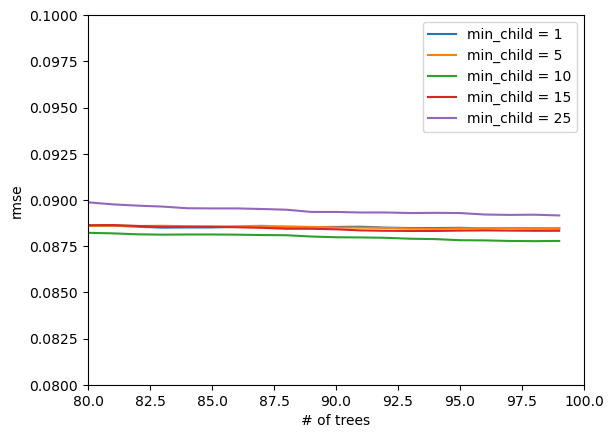

In [126]:
for key_min_child, df_score in scores_min_child.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key_min_child)

plt.ylabel('rmse')
plt.xlabel('# of trees')

#zoom
plt.xlim((80, 100))
plt.ylim((.08, 0.10))

plt.legend()
plt.show()

#min_child = 10

### 2.4 K-Nearest Neighbours Regressor

In [127]:
knn = KNeighborsRegressor(n_neighbors=5)

In [128]:
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [129]:
y_pred = knn.predict(X_val)
y_pred

array([8.31620171, 6.76462482, 7.44051106, ..., 6.6894872 , 6.66128072,
       6.67268971])

In [130]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(0.19105058271329534, 0.9644241493398423)

In [135]:
scores = []

for n in tqdm(range(1, 50)):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    scores.append((n, score, r2))

  0%|          | 0/49 [00:00<?, ?it/s]

In [136]:
columns = ['n_neighbors', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='rmse', ascending=True).head(15)

,n_neighbors,rmse,r2
6,7,0.190813,0.964512
7,8,0.190831,0.964506
5,6,0.190876,0.964489
4,5,0.191051,0.964424
8,9,0.191825,0.964135
9,10,0.192164,0.964008
10,11,0.193072,0.963667
3,4,0.193205,0.963617
11,12,0.193742,0.963415
12,13,0.194230,0.963230


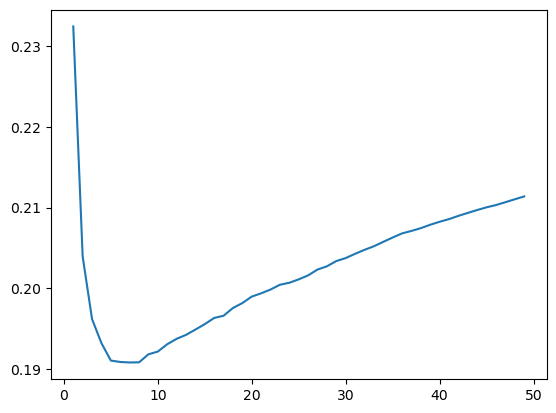

In [137]:
columns = ['n_neighbors','rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_neighbors, df_scores.rmse)
plt.show()

## 3. Selecting the Best Model 

### 3.1 Linear Regression

In [138]:
lreg = LinearRegression()

In [139]:
lreg.fit(X_train, y_train)

LinearRegression()

In [140]:
y_pred = lreg.predict(X_val)

In [141]:
rmse = np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)
r2 = r2_score(y_val, y_pred)
print(f'RMSE Score: {rmse}, R2: {r2}')

RMSE Score: 0.2, R2: 0.9615332535264209


### 3.2 Decision Tree

In [142]:
dt = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)

In [143]:
y_pred = dt.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f'RMSE Score: {score}, R2: {r2}')

RMSE Score: 0.11459039372927123, R2: 0.987201620512506


### 3.3 Random Forest

In [144]:
rf = RandomForestRegressor(n_estimators=180,
                            random_state=1,
                            max_depth=25,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=180, n_jobs=-1, random_state=1)

In [145]:
y_pred = rf.predict(X_val)

In [146]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f'RMSE Score: {score}, R2: {r2}')

RMSE Score: 0.09340165511740384, R2: 0.9914970876078386


### 3.4 XGBoost

In [147]:
%%capture output
xgb_params = {
    'eta': 0.2, 
    'max_depth': 10,
    'min_child_weight': 10,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [148]:
y_pred = model.predict(dval)

In [149]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f'RMSE Score: {score}, R2: {r2}')

RMSE Score: 0.08777826746921308, R2: 0.9924901274022422


### 3.5 K-Nearest Neighbors

In [150]:
knn = KNeighborsRegressor(n_neighbors=7)

In [151]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [152]:
y_pred = knn.predict(X_val)

In [153]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(0.1908132051165119, 0.964512499382788)

## 4. Applying test datset to selected model 

In [154]:
y_full_train = np.log1p(df_full_train.price.values)
del df_full_train['price']

full_train_dicts = df_full_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

y_test = np.log1p(df_test.price.values)
del df_test['price']

test_dicts= df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [187]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [188]:
watchlist = [(dfulltrain, 'full_train'), (dtest, 'test')]

In [189]:
%%capture output
xgb_params = {
    'eta': 0.2, 
    'max_depth': 10,
    'min_child_weight': 10,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain,
                  evals=watchlist,
                  num_boost_round=100)

In [190]:
y_pred = model.predict(dtest)

In [191]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE Score: {score}, R2: {r2}')

RMSE Score: 0.08566971950248659, R2: 0.9927348071790547


<AxesSubplot:ylabel='Count'>

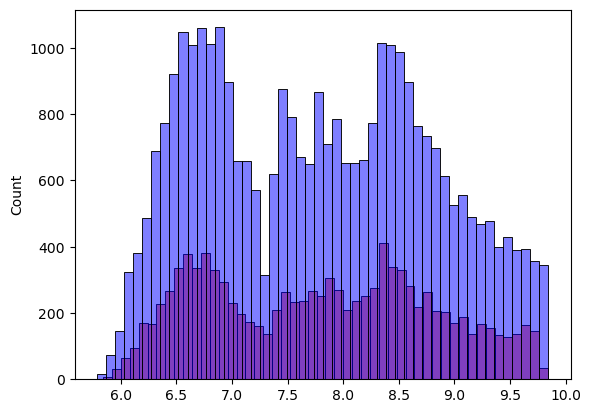

In [192]:
sns.histplot(y_pred, color='red', alpha= 0.5, bins=50)
sns.histplot(y_train, color='blue', alpha= 0.5, bins=50)

In [193]:
predicted_price = np.expm1(y_pred[2])
predicted_price

2583.9475

In [194]:
actual_price = np.expm1(y_test[2])
actual_price

2561.999999999999

In [195]:
predicted_price - actual_price

21.94750976562591

In [196]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    dfulltrain = xgb.DMatrix(X_train, label=y_train)
    
    xgb_params = {
        'eta': 0.2, 
        'max_depth': 10,
        'min_child_weight': 10,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dfulltrain,
                      evals=watchlist,
                      num_boost_round=100)
    return dv, model

In [197]:
def predict(df, dv, model, y_val):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X_val = dv.transform(dicts)
    
    dtest = xgb.DMatrix(X_val, label=y_val)
    
    y_pred = model.predict(dtest)
    
    return y_pred

In [198]:
dv, model = train(df_full_train, y_full_train)

[0]	full_train-rmse:5.88628	test-rmse:5.89607
[1]	full_train-rmse:4.71127	test-rmse:4.71895
[2]	full_train-rmse:3.77147	test-rmse:3.77770
[3]	full_train-rmse:3.01966	test-rmse:3.02449
[4]	full_train-rmse:2.41817	test-rmse:2.42214
[5]	full_train-rmse:1.93707	test-rmse:1.94016
[6]	full_train-rmse:1.55242	test-rmse:1.55474
[7]	full_train-rmse:1.24495	test-rmse:1.24671
[8]	full_train-rmse:0.99912	test-rmse:1.00068
[9]	full_train-rmse:0.80286	test-rmse:0.80421
[10]	full_train-rmse:0.64622	test-rmse:0.64736
[11]	full_train-rmse:0.52126	test-rmse:0.52230
[12]	full_train-rmse:0.42186	test-rmse:0.42285
[13]	full_train-rmse:0.34316	test-rmse:0.34425
[14]	full_train-rmse:0.28090	test-rmse:0.28218
[15]	full_train-rmse:0.23208	test-rmse:0.23361
[16]	full_train-rmse:0.19412	test-rmse:0.19607
[17]	full_train-rmse:0.16481	test-rmse:0.16730
[18]	full_train-rmse:0.14264	test-rmse:0.14568
[19]	full_train-rmse:0.12602	test-rmse:0.12971
[20]	full_train-rmse:0.11379	test-rmse:0.11800
[21]	full_train-rmse:0.

In [199]:
y_pred=predict(df_test, dv, model, y_test)

In [200]:
predict(df_test, dv, model, y_test)[0]

6.202948

In [201]:
predicted_price=np.expm1(predict(df_test, dv, model, y_test)[0])
predicted_price

493.20386

In [202]:
actual_price = np.expm1(y_test[0])
actual_price

564.0000000000002

In [203]:
predicted_price - actual_price

-70.79614257812523

In [204]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE Score: {score}, R2: {r2}')

RMSE Score: 0.08566971950248659, R2: 0.9927348071790547


In [205]:
import bentoml

In [206]:
bentoml.xgboost.save_model("diamond_price_prediction", model,
                          custom_objects={
                              "dictVectorizer": dv
                          })

Model(tag="diamond_price_prediction:7vyl4ztyhsamfahg", path="/Users/humbertorodriguez/bentoml/models/diamond_price_prediction/7vyl4ztyhsamfahg/")

In [207]:
{"carat": 5,
"cut": "Ideal",
"color":"I",
"clarity":"VS1",
"depth": 61.5,
"table": 5.75,
"x": 4.20,
"y":4.23,
"z":2.63}


{'carat': 5,
 'cut': 'Ideal',
 'color': 'I',
 'clarity': 'VS1',
 'depth': 61.5,
 'table': 5.75,
 'x': 4.2,
 'y': 4.23,
 'z': 2.63}